<a href="https://colab.research.google.com/github/ccspen21/greenland-fishery-nowcast-2025/blob/main/model_fitting_diagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install pandas scikit-learn matplotlib

# Clone the repository
!git clone https://github.com/ccspen21/greenland-fishery-nowcast-2025.git

%cd /content/greenland-fishery-nowcast-2025

# Import required libraries
import os
import pandas as pd
import sqlite3
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Ensure compatibility with Colab and GitHub
!apt-get update && apt-get install -y iputils-ping

# Define a configurable database path (pointing to Google Drive)
DB_PATH = os.getenv("DB_PATH", "/content/drive/MyDrive/greenland_fishery.db")

Cloning into 'greenland-fishery-nowcast-2025'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 73 (delta 38), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 594.57 KiB | 4.34 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/greenland-fishery-nowcast-2025
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu ja

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the database file from Google Drive to the current session
import subprocess

try:
    subprocess.run(["cp", DB_PATH, "/content/greenland_fishery.db"], check=True)
    print("Database copied to /content/greenland_fishery.db")
except subprocess.CalledProcessError as e:
    print(f"Error copying database from {DB_PATH} to /content/greenland_fishery.db: {e}")
    raise

Mounted at /content/drive
Database copied to /content/greenland_fishery.db


In [3]:
# Connect to the database
try:
    conn = sqlite3.connect('/content/greenland_fishery.db')
    cursor = conn.cursor()
    print("Connected to SQLite database at /content/greenland_fishery.db")
except Exception as e:
    print(f"Error connecting to database: {e}")
    raise

# Helper function to validate DataFrame against schema (aligned with setup_dataset.ipynb)
def validate_dataframe(df, expected_columns, dtypes):
    if not all(col in df.columns for col in expected_columns):
        raise ValueError(f"DataFrame missing expected columns: {expected_columns}")
    for col, dtype in dtypes.items():
        if col in df.columns:
            if dtype == int:  # Handle integer conversion with NaN
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
            else:
                df[col] = df[col].astype(dtype)
    if df.isnull().any().any():
        raise ValueError(f"DataFrame contains NaN values: {df.head()}")
    if df.empty:
        raise ValueError("DataFrame is empty. Ensure setup_dataset.ipynb has populated the database correctly.")

# Load data from tables with validation
tables = {
    "total_catch": (["Year", "Quarter", "Unit", "Total_Catch"], {"Year": int, "Quarter": str, "Unit": str, "Total_Catch": int}),
    "fish_exports": (["Year", "Quarter", "Fish_Export_Value_Million_Kr"], {"Year": int, "Quarter": str, "Fish_Export_Value_Million_Kr": int}),
    "sst_west": (["Year", "Quarter", "Sea_Surface_Temp_C_West", "Melt_Active_West", "Melt_Index_West"], {"Year": int, "Quarter": str, "Sea_Surface_Temp_C_West": float, "Melt_Active_West": int, "Melt_Index_West": float}),
    "sst_east": (["Year", "Quarter", "Sea_Surface_Temp_C_East", "Melt_Active_East", "Melt_Index_East"], {"Year": int, "Quarter": str, "Sea_Surface_Temp_C_East": float, "Melt_Active_East": int, "Melt_Index_East": float}),
    "sst_south": (["Year", "Quarter", "Sea_Surface_Temp_C_South", "Melt_Active_South", "Melt_Index_South"], {"Year": int, "Quarter": str, "Sea_Surface_Temp_C_South": float, "Melt_Active_South": int, "Melt_Index_South": float}),
    "foreign_catch": (["Year", "Quarter", "Unit", "Foreign_Catch"], {"Year": int, "Quarter": str, "Unit": str, "Foreign_Catch": int}),
}

dataframes = {}
for table_name, (expected_columns, dtypes) in tables.items():
    try:
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        validate_dataframe(df, expected_columns, dtypes)
        dataframes[table_name] = df
        print(f"Loaded {table_name}:")
        display(df.head())
    except Exception as e:
        print(f"Error loading {table_name}: {e}")
        raise  # Stop execution to alert the user to fix the issue

# Assign to variables expected by later cells
df_clean = dataframes["total_catch"]
df_fish_clean = dataframes["fish_exports"]
df_sst_west_clean = dataframes["sst_west"]
df_sst_east_clean = dataframes["sst_east"]
df_sst_south_clean = dataframes["sst_south"]
df_foreign_clean = dataframes["foreign_catch"]

Connected to SQLite database at /content/greenland_fishery.db
Loaded total_catch:


,Year,Quarter,Unit,Total_Catch
0,2011,Q1,Tonnes,25637
1,2011,Q2,Tonnes,16922
2,2011,Q3,Tonnes,34917
3,2011,Q4,Tonnes,24504
4,2012,Q1,Tonnes,46621


Loaded fish_exports:


,Year,Quarter,Fish_Export_Value_Million_Kr
0,2011,Q1,149
1,2011,Q2,174
2,2011,Q3,181
3,2011,Q4,192
4,2012,Q1,133


Loaded sst_west:


,Year,Quarter,Sea_Surface_Temp_C_West,Melt_Active_West,Melt_Index_West
0,2011,Q1,0.342774,0,0.085694
1,2011,Q2,1.515407,1,0.378852
2,2011,Q3,5.736561,1,1.000000
3,2011,Q4,1.325243,1,0.331311
4,2012,Q1,-0.368894,0,0.000000


Loaded sst_east:


,Year,Quarter,Sea_Surface_Temp_C_East,Melt_Active_East,Melt_Index_East
0,2011,Q1,-0.744827,0,0.000000
1,2011,Q2,-0.905921,0,0.000000
2,2011,Q3,2.450244,1,0.612561
3,2011,Q4,0.889492,1,0.222373
4,2012,Q1,-1.145143,0,0.000000


Loaded sst_south:


,Year,Quarter,Sea_Surface_Temp_C_South,Melt_Active_South,Melt_Index_South
0,2011,Q1,3.231249,1,0.807812
1,2011,Q2,2.247865,1,0.561966
2,2011,Q3,5.861202,1,1.000000
3,2011,Q4,4.028882,1,1.000000
4,2012,Q1,1.643930,1,0.410982


Loaded foreign_catch:


,Year,Quarter,Unit,Foreign_Catch
0,2011,Q1,Tonnes,3354
1,2011,Q2,Tonnes,5375
2,2011,Q3,Tonnes,78396
3,2011,Q4,Tonnes,9673
4,2012,Q1,Tonnes,2429


# 3-Way Interaction Term

In [4]:
# Create three-way interaction terms in each SST regional DataFrame
df_sst_west_clean["Melt_SST_Interaction_West"] = (
    df_sst_west_clean["Melt_Active_West"] *
    df_sst_west_clean["Melt_Index_West"] *
    df_sst_west_clean["Sea_Surface_Temp_C_West"]
)

df_sst_east_clean["Melt_SST_Interaction_East"] = (
    df_sst_east_clean["Melt_Active_East"] *
    df_sst_east_clean["Melt_Index_East"] *
    df_sst_east_clean["Sea_Surface_Temp_C_East"]
)

df_sst_south_clean["Melt_SST_Interaction_South"] = (
    df_sst_south_clean["Melt_Active_South"] *
    df_sst_south_clean["Melt_Index_South"] *
    df_sst_south_clean["Sea_Surface_Temp_C_South"]
)

# Merged Dataset

In [5]:
# Ensure all 'Year' and 'Quarter' columns are of consistent type across DataFrames
# Align with setup_dataset.ipynb: Quarter is categorical and ordered
for df in [df_clean, df_fish_clean, df_foreign_clean, df_sst_west_clean, df_sst_east_clean, df_sst_south_clean]:
    df["Year"] = df["Year"].astype(int)
    df["Quarter"] = pd.Categorical(df["Quarter"], categories=["Q1", "Q2", "Q3", "Q4"], ordered=True)

# Start fresh from df_clean
df_merged_with_interactions = df_clean.copy()

# Merge standard right-hand-side variables
df_merged_with_interactions = df_merged_with_interactions.merge(df_fish_clean, on=["Year", "Quarter"], how="inner")

# Merge SST interaction terms
df_merged_with_interactions = df_merged_with_interactions.merge(
    df_sst_west_clean[["Year", "Quarter", "Melt_SST_Interaction_West"]],
    on=["Year", "Quarter"], how="inner"
).merge(
    df_sst_east_clean[["Year", "Quarter", "Melt_SST_Interaction_East"]],
    on=["Year", "Quarter"], how="inner"
).merge(
    df_sst_south_clean[["Year", "Quarter", "Melt_SST_Interaction_South"]],
    on=["Year", "Quarter"], how="inner"
)

# Merge foreign catch
df_merged_with_interactions = df_merged_with_interactions.merge(
    df_foreign_clean.drop(columns=["Unit"]),
    on=["Year", "Quarter"], how="left"
)

# Drop unnecessary columns
df_merged_with_interactions = df_merged_with_interactions.drop(
    columns=[col for col in df_merged_with_interactions.columns if "Unit" in col], errors="ignore"
)

# Log dropped rows after merging and handle NaN in Foreign_Catch
if df_merged_with_interactions["Foreign_Catch"].isnull().any():
    print(f"Found {df_merged_with_interactions['Foreign_Catch'].isnull().sum()} NaN values in Foreign_Catch. Filling with 0.")
    df_merged_with_interactions["Foreign_Catch"] = df_merged_with_interactions["Foreign_Catch"].fillna(0)

original_len = len(df_merged_with_interactions)
df_merged_with_interactions = df_merged_with_interactions.dropna()
dropped_rows = original_len - len(df_merged_with_interactions)
if dropped_rows > 0:
    print(f"Dropped {dropped_rows} rows due to missing values after merging")

# Order (already categorical, just sort)
df_merged_with_interactions = df_merged_with_interactions.sort_values(by=["Year", "Quarter"]).reset_index(drop=True)

print("✅ Final merged dataset shape:", df_merged_with_interactions.shape)
display(df_merged_with_interactions.head())

✅ Final merged dataset shape: (56, 8)


,Year,Quarter,Total_Catch,Fish_Export_Value_Million_Kr,Melt_SST_Interaction_West,Melt_SST_Interaction_East,Melt_SST_Interaction_South,Foreign_Catch
0,2011,Q1,25637,149,0.000000,-0.000000,2.610242,3354
1,2011,Q2,16922,174,0.574115,-0.000000,1.263224,5375
2,2011,Q3,34917,181,5.736561,1.500924,5.861202,78396
3,2011,Q4,24504,192,0.439067,0.197799,4.028882,9673
4,2012,Q1,46621,133,-0.000000,-0.000000,0.675626,2429


# LASSO Regression

In [6]:
# Step 1: Identify predictors to lag (exclude Total_Catch and lagged versions)
predictor_cols = [
    col for col in df_merged_with_interactions.columns
    if col not in ["Year", "Quarter", "Total_Catch"]
    and not col.endswith("_lag1")
    and not col.endswith("_lag2")
    and not col.endswith("_lag3")
    and not col.endswith("_lag4")
]

print("🔍 Predictors to lag:", predictor_cols)

# Step 2: Add lags 1–4 for each selected predictor
for col in predictor_cols:
    for lag in [1, 2, 3, 4]:
        df_merged_with_interactions[f"{col}_lag{lag}"] = df_merged_with_interactions[col].shift(lag)

# Step 3: Add lags 1–4 for Total_Catch
for lag in [1, 2, 3, 4]:
    df_merged_with_interactions[f"Total_Catch_lag{lag}"] = df_merged_with_interactions["Total_Catch"].shift(lag)

# Step 4: Drop original (non-lagged) predictors
df_model_with_interactions = df_merged_with_interactions.drop(columns=predictor_cols)

# Step 5: Drop rows with NA from lagging
df_model_with_interactions = df_model_with_interactions.dropna().reset_index(drop=True)

# Step 6: Define modeling dataset
y = df_model_with_interactions["Total_Catch"]
X = df_model_with_interactions.drop(columns=["Year", "Quarter", "Total_Catch"])

# ✅ Final shape check
print("✅ Clean setup with lags 1–4 — X shape:", X.shape, "y shape:", y.shape)

🔍 Predictors to lag: ['Fish_Export_Value_Million_Kr', 'Melt_SST_Interaction_West', 'Melt_SST_Interaction_East', 'Melt_SST_Interaction_South', 'Foreign_Catch']
✅ Clean setup with lags 1–4 — X shape: (52, 24) y shape: (52,)


# Selected Variables

✅ Selected variables with 4 lags:
 Fish_Export_Value_Million_Kr_lag2    -704.368402
Melt_SST_Interaction_West_lag1       -286.749934
Melt_SST_Interaction_West_lag4       3545.309113
Melt_SST_Interaction_East_lag1      -2172.740943
Foreign_Catch_lag3                  -1234.599671
Foreign_Catch_lag4                  -2382.560846
Total_Catch_lag1                    -2835.471528
Total_Catch_lag4                     4174.877857
dtype: float64


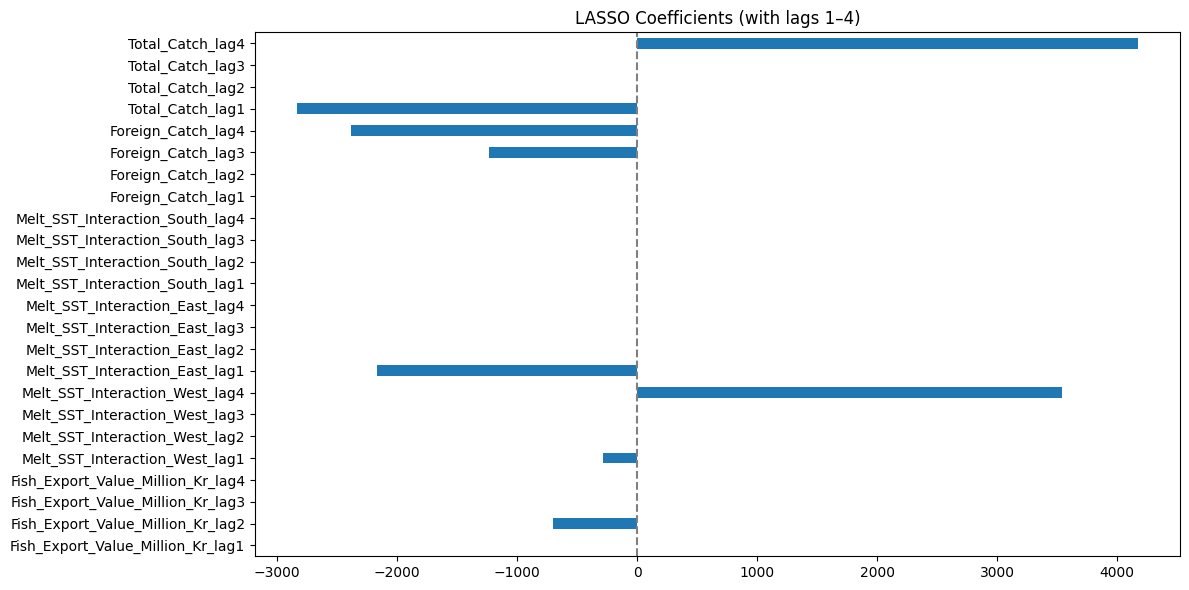

In [7]:
# Step 1: Create LASSO pipeline with standardization and cross-validated alpha
lasso_pipeline = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, random_state=42, max_iter=50000)
)

# Step 2: Fit the model
lasso_pipeline.fit(X, y)

# Step 3: Extract coefficients into a clean DataFrame
lasso_model = lasso_pipeline.named_steps["lassocv"]
coef = pd.Series(lasso_model.coef_, index=X.columns)

# Step 4: Display selected variables (non-zero)
selected = coef[coef != 0]
print("✅ Selected variables with 4 lags:\n", selected)

# Step 5: Plot all coefficients
plt.figure(figsize=(12, 6))
coef.plot(kind='barh')
plt.title("LASSO Coefficients (with lags 1–4)")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


# **Evaluation**

# LASSO Coefficients

In [15]:
import pandas as pd

# Extract fitted models from pipelines
lasso_model = lasso_pipeline_q1.named_steps['lasso']

# Define variable names used
feature_names = [
    "Total_Catch_lag4",
    "Foreign Catch_lag4",
    "Melt_SST_Interaction - West_lag4",
    "Melt_SST_Interaction - East_lag1",
    "Fish Export Value (Million Kr)_lag2"
]

# Create a DataFrame of coefficients
coef_df = pd.DataFrame({
    "LASSO": lasso_model.coef_,
}, index=feature_names)

# Round for cleaner display
coef_df = coef_df.round(0).astype(int)

# Display
display(coef_df)

,LASSO
Total_Catch_lag4,6549
Foreign Catch_lag4,-5796
Melt_SST_Interaction - West_lag4,5095
Melt_SST_Interaction - East_lag1,-4615
Fish Export Value (Million Kr)_lag2,-2232


# Out-of-Sample Performance - Backtests

# Q4 2024

In [10]:
# Step 1: Filter training data (up to Q3 2024 only)
train_q4 = df_model_with_interactions[
    (df_model_with_interactions["Year"] < 2024) |
    ((df_model_with_interactions["Year"] == 2024) & (df_model_with_interactions["Quarter"] < "Q4"))
]

X_train_q4 = train_q4[[
    "Total_Catch_lag4",
    "Melt_SST_Interaction_West_lag4",
    "Foreign_Catch_lag4",
    "Melt_SST_Interaction_East_lag1",
    "Fish_Export_Value_Million_Kr_lag2"
]]

y_train_q4 = train_q4["Total_Catch"]
print("✅ Training set size for Q4 2024 (Top 5 Vars):", X_train_q4.shape)

# Step 2: Create nowcast input row for Q4 2024
try:
    latest_row_q3 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2024) & (df_model_with_interactions["Quarter"] == "Q3")
    ].iloc[0]
except IndexError:
    print("Error: Q3 2024 data not found. Ensure periodic_update.ipynb has been run to fetch the latest data.")
    raise

X_nowcast_q4 = pd.DataFrame([{
    "Total_Catch_lag4": df_model_with_interactions.iloc[-5]["Total_Catch_lag4"],                          # Q4 2023
    "Melt_SST_Interaction_West_lag4": df_model_with_interactions.iloc[-5]["Melt_SST_Interaction_West_lag4"],
    "Foreign_Catch_lag4": df_model_with_interactions.iloc[-5]["Foreign_Catch_lag4"],
    "Melt_SST_Interaction_East_lag1": df_model_with_interactions.iloc[-2]["Melt_SST_Interaction_East_lag1"],
    "Fish_Export_Value_Million_Kr_lag2": df_model_with_interactions.iloc[-5]["Fish_Export_Value_Million_Kr_lag2"]
}])

print("✅ Nowcast input row for Q4 2024 (5 vars):")
display(X_nowcast_q4)

# Step 3: Fit LASSO model
lasso_pipeline_q4 = make_pipeline(
    StandardScaler(),
    Lasso(alpha=1.0, max_iter=10000)
)

lasso_pipeline_q4.fit(X_train_q4, y_train_q4)

# Step 4: Predict Q4 2024
y_pred_q4_2024_lasso = lasso_pipeline_q4.predict(X_nowcast_q4)[0]
print(f"📈 🧪 Nowcast for Q4 2024 (LASSO, Fish Export included): {round(y_pred_q4_2024_lasso):,.0f} tons")

# Step 5: Compare with actual
try:
    actual_q4 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2024) & (df_model_with_interactions["Quarter"] == "Q4")
    ]["Total_Catch"].values[0]
except IndexError:
    print("Error: Q4 2024 actual data not found. Cannot compute forecast error.")
    raise

error_q4 = y_pred_q4_2024_lasso - actual_q4
print(f"🎯 Actual Q4 2024: {round(actual_q4):,.0f} tons")
print(f"🔍 Forecast Error: {round(error_q4):,.0f} tons ({round(100 * error_q4 / actual_q4, 1)}%)")

✅ Training set size for Q4 2024 (Top 5 Vars): (51, 5)
✅ Nowcast input row for Q4 2024 (5 vars):


,Total_Catch_lag4,Melt_SST_Interaction_West_lag4,Foreign_Catch_lag4,Melt_SST_Interaction_East_lag1,Fish_Export_Value_Million_Kr_lag2
0,33097.0,0.757776,5021.0,-0.0,304.0


📈 🧪 Nowcast for Q4 2024 (LASSO, Fish Export included): 37,258 tons
🎯 Actual Q4 2024: 36,753 tons
🔍 Forecast Error: 505 tons (1.4%)


# Q3 2024

In [11]:
# Step 1: Filter training data up to Q2 2024 (exclude Q3)
train_q3 = df_model_with_interactions[
    (df_model_with_interactions["Year"] < 2024) |
    ((df_model_with_interactions["Year"] == 2024) & (df_model_with_interactions["Quarter"] < "Q3"))
]

X_train_q3 = train_q3[[
    "Total_Catch_lag4",
    "Melt_SST_Interaction_West_lag4",
    "Foreign_Catch_lag4",
    "Melt_SST_Interaction_East_lag1",
    "Fish_Export_Value_Million_Kr_lag2"
]]
y_train_q3 = train_q3["Total_Catch"]
print("✅ Training set size for Q3 2024 (5 vars):", X_train_q3.shape)

# Step 2: Create nowcast input row for Q3 2024
try:
    latest_row_q2 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2024) & (df_model_with_interactions["Quarter"] == "Q2")
    ].iloc[0]
except IndexError:
    print("Error: Q2 2024 data not found. Ensure periodic_update.ipynb has been run to fetch the latest data.")
    raise

X_nowcast_q3 = pd.DataFrame([{
    "Total_Catch_lag4": df_model_with_interactions.iloc[-6]["Total_Catch_lag4"],                          # Q3 2023
    "Melt_SST_Interaction_West_lag4": df_model_with_interactions.iloc[-6]["Melt_SST_Interaction_West_lag4"],
    "Foreign_Catch_lag4": df_model_with_interactions.iloc[-6]["Foreign_Catch_lag4"],
    "Melt_SST_Interaction_East_lag1": df_model_with_interactions.iloc[-3]["Melt_SST_Interaction_East_lag1"],
    "Fish_Export_Value_Million_Kr_lag2": df_model_with_interactions.iloc[-6]["Fish_Export_Value_Million_Kr_lag2"]
}])

print("✅ Nowcast input row for Q3 2024 (5 vars):")
display(X_nowcast_q3)

# Step 3: Fit LASSO model
lasso_pipeline_q3 = make_pipeline(
    StandardScaler(),
    Lasso(alpha=1.0, max_iter=10000)
)

lasso_pipeline_q3.fit(X_train_q3, y_train_q3)

# Step 4: Predict Q3 2024
y_pred_q3_2024_lasso = lasso_pipeline_q3.predict(X_nowcast_q3)[0]
print(f"📈 🧪 Nowcast for Q3 2024 (LASSO, Fish Export included): {round(y_pred_q3_2024_lasso):,.0f} tons")

# Step 5: Compare with actual
try:
    actual_q3 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2024) & (df_model_with_interactions["Quarter"] == "Q3")
    ]["Total_Catch"].values[0]
except IndexError:
    print("Error: Q3 2024 actual data not found. Cannot compute forecast error.")
    raise

error_q3 = y_pred_q3_2024_lasso - actual_q3
print(f"🎯 Actual Q3 2024: {round(actual_q3):,.0f} tons")
print(f"🔍 Forecast Error: {round(error_q3):,.0f} tons ({round(100 * error_q3 / actual_q3, 1)}%)")

✅ Training set size for Q3 2024 (5 vars): (50, 5)
✅ Nowcast input row for Q3 2024 (5 vars):


,Total_Catch_lag4,Melt_SST_Interaction_West_lag4,Foreign_Catch_lag4,Melt_SST_Interaction_East_lag1,Fish_Export_Value_Million_Kr_lag2
0,39104.0,4.867929,7068.0,-0.0,187.0


📈 🧪 Nowcast for Q3 2024 (LASSO, Fish Export included): 52,052 tons
🎯 Actual Q3 2024: 35,727 tons
🔍 Forecast Error: 16,325 tons (45.7%)


# Q2 2024

In [12]:
q2_vars = [
    "Total_Catch_lag4",
    "Foreign_Catch_lag4",
    "Melt_SST_Interaction_West_lag4",
    "Melt_SST_Interaction_East_lag1",
    "Fish_Export_Value_Million_Kr_lag2"
]

# Step 1: Training data up to Q1 2024 (exclude Q2)
train_q2 = df_model_with_interactions[
    (df_model_with_interactions["Year"] < 2024) |
    ((df_model_with_interactions["Year"] == 2024) & (df_model_with_interactions["Quarter"] < "Q2"))
]

X_train_q2 = train_q2[[
    "Total_Catch_lag4",
    "Foreign_Catch_lag4",
    "Melt_SST_Interaction_West_lag4",
    "Melt_SST_Interaction_East_lag1",
    "Fish_Export_Value_Million_Kr_lag2"
]]
y_train_q2 = train_q2["Total_Catch"]

print("✅ Training set size for Q2 2024 (LASSO):", X_train_q2.shape)

# Step 2: Create nowcast input row for Q2 2024
try:
    latest_row_q1 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2024) &
        (df_model_with_interactions["Quarter"] == "Q1")
    ].iloc[0]
except IndexError:
    print("Error: Q1 2024 data not found. Ensure periodic_update.ipynb has been run to fetch the latest data.")
    raise

X_nowcast_q2 = pd.DataFrame([{
    "Total_Catch_lag4": df_model_with_interactions.iloc[-7]["Total_Catch_lag4"],  # Q2 2023
    "Foreign_Catch_lag4": df_model_with_interactions.iloc[-7]["Foreign_Catch_lag4"],
    "Melt_SST_Interaction_West_lag4": df_model_with_interactions.iloc[-7]["Melt_SST_Interaction_West_lag4"],
    "Melt_SST_Interaction_East_lag1": df_model_with_interactions.iloc[-4]["Melt_SST_Interaction_East_lag1"],  # Q1 2024
    "Fish_Export_Value_Million_Kr_lag2": df_model_with_interactions.iloc[-7]["Fish_Export_Value_Million_Kr_lag2"]
}])

print("✅ Nowcast input for Q2 2024 (LASSO):")
display(X_nowcast_q2)

# Step 3: Fit LASSO pipeline
lasso_pipeline_q2 = make_pipeline(
    StandardScaler(),
    Lasso(alpha=1.0, max_iter=10000)
)

lasso_pipeline_q2.fit(X_train_q2, y_train_q2)
y_pred_q2_2024_lasso = lasso_pipeline_q2.predict(X_nowcast_q2)[0]

# Step 4: Compare with actual
try:
    actual_q2 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2024) &
        (df_model_with_interactions["Quarter"] == "Q2")
    ]["Total_Catch"].values[0]
except IndexError:
    print("Error: Q2 2024 actual data not found. Cannot compute forecast error.")
    raise

error_q2_lasso = y_pred_q2_2024_lasso - actual_q2
print(f"📊 LASSO Nowcast for Q2 2024: {round(y_pred_q2_2024_lasso):,.0f} tons")
print(f"🎯 Actual Q2 2024: {round(actual_q2):,.0f} tons")
print(f"🔍 Forecast Error: {round(error_q2_lasso):,.0f} tons ({round(100 * error_q2_lasso / actual_q2, 1)}%)")

✅ Training set size for Q2 2024 (LASSO): (49, 5)
✅ Nowcast input for Q2 2024 (LASSO):


,Total_Catch_lag4,Foreign_Catch_lag4,Melt_SST_Interaction_West_lag4,Melt_SST_Interaction_East_lag1,Fish_Export_Value_Million_Kr_lag2
0,45246.0,9258.0,0.0,0.363192,406.0


📊 LASSO Nowcast for Q2 2024: 34,120 tons
🎯 Actual Q2 2024: 30,549 tons
🔍 Forecast Error: 3,571 tons (11.7%)


# Q1 2024

In [13]:
# Step 1: Training data up to Q4 2023 (exclude Q1 2024)
train_q1 = df_model_with_interactions[
    (df_model_with_interactions["Year"] < 2024)
]

X_train_q1 = train_q1[[
    "Total_Catch_lag4",
    "Foreign_Catch_lag4",
    "Melt_SST_Interaction_West_lag4",
    "Melt_SST_Interaction_East_lag1",
    "Fish_Export_Value_Million_Kr_lag2"
]]
y_train_q1 = train_q1["Total_Catch"]

print("✅ Training set size for Q1 2024 (LASSO):", X_train_q1.shape)

# Step 2: Create nowcast input row for Q1 2024
try:
    latest_row_q4_2023 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2023) &
        (df_model_with_interactions["Quarter"] == "Q4")
    ].iloc[0]
except IndexError:
    print("Error: Q4 2023 data not found. Ensure setup_dataset.ipynb or periodic_update.ipynb has been run to fetch the latest data.")
    raise

X_nowcast_q1 = pd.DataFrame([{
    "Total_Catch_lag4": df_model_with_interactions.iloc[-8]["Total_Catch_lag4"],  # Q1 2023
    "Foreign_Catch_lag4": df_model_with_interactions.iloc[-8]["Foreign_Catch_lag4"],
    "Melt_SST_Interaction_West_lag4": df_model_with_interactions.iloc[-8]["Melt_SST_Interaction_West_lag4"],
    "Melt_SST_Interaction_East_lag1": df_model_with_interactions.iloc[-5]["Melt_SST_Interaction_East_lag1"],  # Q4 2023
    "Fish_Export_Value_Million_Kr_lag2": df_model_with_interactions.iloc[-8]["Fish_Export_Value_Million_Kr_lag2"]
}])

print("✅ Nowcast input for Q1 2024 (LASSO):")
display(X_nowcast_q1)

# Step 3: Fit LASSO model
lasso_pipeline_q1 = make_pipeline(
    StandardScaler(),
    Lasso(alpha=1.0, max_iter=10000)
)

lasso_pipeline_q1.fit(X_train_q1, y_train_q1)
y_pred_q1_2024_lasso = lasso_pipeline_q1.predict(X_nowcast_q1)[0]

# Step 4: Compare with actual
try:
    actual_q1 = df_model_with_interactions[
        (df_model_with_interactions["Year"] == 2024) &
        (df_model_with_interactions["Quarter"] == "Q1")
    ]["Total_Catch"].values[0]
except IndexError:
    print("Error: Q1 2024 actual data not found. Cannot compute forecast error.")
    raise

error_q1_lasso = y_pred_q1_2024_lasso - actual_q1
print(f"📊 LASSO Nowcast for Q1 2024: {round(y_pred_q1_2024_lasso):,.0f} tons")
print(f"🎯 Actual Q1 2024: {round(actual_q1):,.0f} tons")
print(f"🔍 Forecast Error: {round(error_q1_lasso):,.0f} tons ({round(100 * error_q1_lasso / actual_q1, 1)}%)")

✅ Training set size for Q1 2024 (LASSO): (48, 5)
✅ Nowcast input for Q1 2024 (LASSO):


,Total_Catch_lag4,Foreign_Catch_lag4,Melt_SST_Interaction_West_lag4,Melt_SST_Interaction_East_lag1,Fish_Export_Value_Million_Kr_lag2
0,72143.0,4605.0,-0.0,3.460503,288.0


📊 LASSO Nowcast for Q1 2024: 42,120 tons
🎯 Actual Q1 2024: 36,862 tons
🔍 Forecast Error: 5,258 tons (14.3%)


# MAE for Backtests

In [14]:
# Q1 MAE
mae_q1_lasso = abs(y_pred_q1_2024_lasso - actual_q1)

# Q2 MAE
mae_q2_lasso = abs(y_pred_q2_2024_lasso - actual_q2)

# Q3 MAE
mae_q3_lasso = abs(y_pred_q3_2024_lasso - actual_q3)

# Q4 MAE
mae_q4_lasso = abs(y_pred_q4_2024_lasso - actual_q4)

# Average MAE across all quarters
avg_mae_lasso = (mae_q1_lasso + mae_q2_lasso + mae_q3_lasso + mae_q4_lasso) / 4

# Display the MAE comparison table
print("📊 MAE Comparison Table (Q1–Q4 2024 Backtests)")
print("------------------------------------------------")
print(f"Q1 2024 MAE - LASSO:        {mae_q1_lasso:,.0f}")
print(f"Q2 2024 MAE - LASSO:        {mae_q2_lasso:,.0f}")
print(f"Q3 2024 MAE - LASSO:        {mae_q3_lasso:,.0f}")
print(f"Q4 2024 MAE - LASSO:        {mae_q4_lasso:,.0f}")
print("------------------------------------------------")
print(f"Avg MAE     - LASSO:        {avg_mae_lasso:,.0f}")

📊 MAE Comparison Table (Q1–Q4 2024 Backtests)
------------------------------------------------
Q1 2024 MAE - LASSO:        5,258
Q2 2024 MAE - LASSO:        3,571
Q3 2024 MAE - LASSO:        16,325
Q4 2024 MAE - LASSO:        505
------------------------------------------------
Avg MAE     - LASSO:        6,415


In [16]:
# Save Backtest Results to Google Drive
import pandas as pd

# Collect backtest results into a DataFrame
backtest_results = pd.DataFrame({
    "Quarter": ["Q1 2024", "Q2 2024", "Q3 2024", "Q4 2024"],
    "Actual": [actual_q1, actual_q2, actual_q3, actual_q4],
    "Predicted": [y_pred_q1_2024_lasso, y_pred_q2_2024_lasso, y_pred_q3_2024_lasso, y_pred_q4_2024_lasso]
})

# Save to Google Drive
backtest_results.to_csv('/content/drive/MyDrive/backtest_results_2024.csv', index=False)
print("✅ Backtest results saved to Google Drive at /content/drive/MyDrive/backtest_results_2024.csv")

✅ Backtest results saved to Google Drive at /content/drive/MyDrive/backtest_results_2024.csv


# In-Sample Performance

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ✅ In-sample predictions (using Q1 training data)
y_pred_lasso_train = lasso_pipeline_q1.predict(X_train_q1)

# ✅ LASSO metrics
print("🔍 LASSO In-Sample Performance:")
print("MAE:", mean_absolute_error(y_train_q1, y_pred_lasso_train))

mean_total_catch = df_clean["Total_Catch"].mean()
mae_percent = (11095 / mean_total_catch) * 100
print(f"MAE as % of average total catch: {mae_percent:.2f}%")


🔍 LASSO In-Sample Performance:
MAE: 11129.235723468004
MAE as % of average total catch: 28.56%


Given the nature of fish catch in Greenland, which is heavily influenced by policy shocks, quota trading, and environmental volatility, MAE is a more appropriate metric than RMSE or R². It offers a stable, interpretable measure of predictive accuracy that reflects the average deviation in real-world units (tons), without over-penalizing policy-driven anomalies.

In [18]:
# Close the database connection
try:
    conn.close()
    print("Database connection closed.")
except Exception as e:
    print(f"Error closing database connection: {e}")

Database connection closed.
